In [1]:
!nvidia-smi

Wed Aug  2 14:36:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB            Off| 00000000:41:00.0 Off |                    0 |
| N/A   42C    P0               38W / 250W|      0MiB / 32768MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import segmentation_models as sm
import pandas as pd


Segmentation Models: using `tf.keras` framework.


In [3]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## utils

In [4]:
def get_1c_PT_unet(weights_path):
    N = 1
    BACKBONE = 'resnet18'
    preprocess_input1 = sm.get_preprocessing(BACKBONE)
    base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')
    inp = Input(shape =(None,None, N))
    l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
    out = base_model(l1)
    model = Model(inp, out, name=base_model.name)
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    #checkpoint_path = 'models/bf_to_gut_tl/set4patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.hdf5'
    checkpoint_path = weights_path
    model.load_weights(checkpoint_path)
    return model

def get_2c_PT_unet(weights_path):
    N = 2
    BACKBONE = 'resnet18'
    preprocess_input1 = sm.get_preprocessing(BACKBONE)
    base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')
    inp = Input(shape =(None,None, N))
    l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
    out = base_model(l1)
    model = Model(inp, out, name=base_model.name)
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    #checkpoint_path = 'models/bf_to_gut_tl/set4patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.hdf5'
    checkpoint_path = weights_path
    model.load_weights(checkpoint_path)
    return model

def center_norm_im_float32(images,return_m_std = False):
    images_float = images.astype(np.float32)
    mean = np.mean(images_float)
    std = np.std(images_float)
    normalized_stack = (images_float-mean)/std
    if return_m_std:
        return normalized_stack,mean,std
    else:
        return normalized_stack

def get_b_block(p_shape = (31, 15, 15, 65536),outshape = (2048,2048),plot = False):
    block = np.ones((p_shape[1]+1,p_shape[2]+1),dtype = np.float32)
    triangle_size = 5
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            # Replace the pixels of the upper right triangle with the ones from the lower left triangle
            if j > i+triangle_size or i > j+triangle_size:
                block[i,j] = 0

    height_scale = int(outshape[0]/(p_shape[1]+1)) # should be 128
    width_scale = int(outshape[1]/(p_shape[2]+1)) # should be 128
    b_block = np.repeat(np.repeat(block, height_scale, axis=0), width_scale, axis=1)
    
    if plot:
        plt.figure(figsize = [4,2])
        plt.subplot(121)
        plt.imshow(block)
        plt.subplot(122)
        plt.imshow(b_block)
    return b_block

def compute_iou(pred,mask):
    intersection = np.logical_and(mask, pred)
    union = np.logical_or(mask, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    #print("IoU socre is: ", iou_score)
    return iou_score

def compute_analysis_stacks(pred_stack,mask_stack):
    truePos_stack = mask_stack*pred_stack
    falseNeg_stack = mask_stack - truePos_stack
    falsePos_stack = pred_stack - truePos_stack
    return truePos_stack, falseNeg_stack, falsePos_stack

def compute_analysis_stacks_fluor(pred_stack,mask_stack,fluor_stack):
    truePos_stack = (mask_stack*pred_stack)*fluor_stack
    falseNeg_stack = (mask_stack - mask_stack*pred_stack)*fluor_stack
    falsePos_stack = (pred_stack - mask_stack*pred_stack)*fluor_stack
    return truePos_stack, falseNeg_stack, falsePos_stack

def compute_precision_recall_f1(pred_stack,mask_stack):
    '''computes the precision recall and F1 score across all pixels over all images
    takes in the prediction binary maskes, and the ground truth binary masks '''
    truePos_stack = mask_stack*pred_stack
    falseNeg_stack = mask_stack - truePos_stack
    falsePos_stack = pred_stack - truePos_stack
    
    recall = np.sum(truePos_stack)/(np.sum(truePos_stack)+np.sum(falseNeg_stack)+0.000001)
    precision = np.sum(truePos_stack)/(np.sum(truePos_stack)+np.sum(falsePos_stack)+0.000001)
    F1 = 2*precision*recall/(precision+recall+0.000001)
    return precision,recall,F1

def compute_precision_recall_f1_imagewise(pred_stack,mask_stack):
    '''computes the precision recall and F1 score across images idividually
    takes in the prediction binary maskes, and the ground truth binary masks '''
    truePos_stack = mask_stack*pred_stack
    falseNeg_stack = mask_stack - truePos_stack
    falsePos_stack = pred_stack - truePos_stack
    
    recall = np.sum(truePos_stack, axis=(-2, -1))/(np.sum(truePos_stack, axis=(-2, -1))+np.sum(falseNeg_stack, axis=(-2, -1))+0.000001)
    precision = np.sum(truePos_stack, axis=(-2, -1))/(np.sum(truePos_stack, axis=(-2, -1))+np.sum(falsePos_stack, axis=(-2, -1))+0.000001)
    F1 = 2*precision*recall/(precision+recall+0.000001)
    return precision,recall,F1

def compute_precision_recall_f1_fluor(pred_stack,mask_stack,fluor_stack):
    '''computes the precision recall and *F1 score across all pixels over all images
    takes in the prediction binary maskes the ground truth binary masks and the fourescent images stacks
    *F1 is a particular metric that is F1 but weighted based on the fluorescence value that is collected'''
    truePos_stack = (mask_stack*pred_stack)*fluor_stack
    falseNeg_stack = (mask_stack - mask_stack*pred_stack)*fluor_stack
    falsePos_stack = (pred_stack - mask_stack*pred_stack)*fluor_stack
    
    recall = np.sum(truePos_stack)/(np.sum(truePos_stack)+np.sum(falseNeg_stack)+0.000001)
    precision = np.sum(truePos_stack)/(np.sum(truePos_stack)+np.sum(falsePos_stack)+0.000001)
    F1 = 2*precision*recall/(precision+recall+0.000001)
    return precision,recall,F1

def compute_precision_recall_f1_fluor_imagewise(pred_stack,mask_stack,fluor_stack):
    '''computes the precision recall and *F1 score for each individual image. 
    this is a particular metric that is weighted based on the fluorescence value that is collected'''
    truePos_stack = (mask_stack*pred_stack)*fluor_stack
    falseNeg_stack = (mask_stack - mask_stack*pred_stack)*fluor_stack
    falsePos_stack = (pred_stack - mask_stack*pred_stack)*fluor_stack
    
    recall = np.sum(truePos_stack, axis=(-2, -1))/(np.sum(truePos_stack, axis=(-2, -1))+np.sum(falseNeg_stack, axis=(-2, -1))+0.000001)
    precision = np.sum(truePos_stack, axis=(-2, -1))/(np.sum(truePos_stack, axis=(-2, -1))+np.sum(falsePos_stack, axis=(-2, -1))+0.000001)
    F1 = 2*precision*recall/(precision+recall+0.000001)
    return precision,recall,F1

def compute_evals_gm_bm_fluor(predictions_CB,gutmask_stack,bactmask_stack,green_stack_bs,red_stack_bs):
    model_evals = {}

    p,r,f1 = compute_precision_recall_f1(predictions_CB,gutmask_stack)
    pg,rg,f1g = compute_precision_recall_f1_fluor(predictions_CB,gutmask_stack,green_stack_bs)
    pr,rr,f1r = compute_precision_recall_f1_fluor(predictions_CB,gutmask_stack,red_stack_bs)
    iou = compute_iou(predictions_CB,gutmask_stack)
    model_evals.update({'iou':iou,
                        'gutmask_precision':p,'gutmask_recall':r,'gutmask_f1':f1,
                        'gfp_gutmask_precision':pg,'gfp_gutmask_recall':rg,'gfp_gutmask_f1':f1g,
                        'rfp_gutmask_precision':pr,'rfp_gutmask_recall':rr,'rfp_gutmask_f1':f1r})

    # compute imagewise
    p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,gutmask_stack)
    pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,green_stack_bs)
    pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,red_stack_bs)
    n = len(p)

    model_evals.update({'gutmask_perim_avg_precision':np.mean(p),'gutmask_perim_avg_recall':np.mean(r),'gutmask_perim_avg_f1':np.mean(f1),
                        'gfp_gutmask_perim_avg_precision':np.mean(pg),'gfp_gutmask_perim_avg_recall':np.mean(rg),'gfp_gutmask_perim_avg_f1':np.mean(f1g),
                        'rfp_gutmask_perim_avg_precision':np.mean(pr),'rfp_gutmask_perim_avg_recall':np.mean(rr),'rfp_gutmask_perim_avg_f1':np.mean(f1r),
                        'gutmask_perim_se_precision':np.std(p)/np.sqrt(n),'gutmask_perim_se_recall':np.std(r)/np.sqrt(n),'gutmask_perim_se_f1':np.std(f1)/np.sqrt(n),
                        'gfp_gutmask_perim_se_precision':np.std(pg)/np.sqrt(n),'gfp_gutmask_perim_se_recall':np.std(rg)/np.sqrt(n),'gfp_gutmask_perim_se_f1':np.std(f1g)/np.sqrt(n),
                        'rfp_gutmask_perim_se_precision':np.std(pr)/np.sqrt(n),'rfp_gutmask_perim_se_recall':np.std(rr)/np.sqrt(n),'rfp_gutmask_perim_se_f1':np.std(f1r)/np.sqrt(n)})

    # compute on the bactmask
    p,r,f1 = compute_precision_recall_f1(predictions_CB,bactmask_stack)
    pg,rg,f1g = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,green_stack_bs)
    pr,rr,f1r = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,red_stack_bs)
    iou = compute_iou(predictions_CB,bactmask_stack)
    model_evals.update({'iou_bm':iou,
                   'bactmask_precision':p,'bactmask_recall':r,'bactmask_f1':f1,
                  'gfp_bactmask_precision':pg,'gfp_bactmask_recall':rg,'gfp_bactmask_f1':f1g,
                  'rfp_bactmask_precision':pr,'rfp_bactmask_recall':rr,'rfp_bactmask_f1':f1r})

    # compute on bact masks imagewise
    p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,bactmask_stack)
    pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,bactmask_stack,green_stack_bs)
    pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,bactmask_stack,red_stack_bs)

    model_evals.update({'bactmask_perim_avg_precision':np.mean(p),'bactmask_perim_avg_recall':np.mean(r),'bactmask_perim_avg_f1':np.mean(f1),
                        'gfp_bactmask_perim_avg_precision':np.mean(pg),'gfp_bactmask_perim_avg_recall':np.mean(rg),'gfp_bactmask_perim_avg_f1':np.mean(f1g),
                        'rfp_bactmask_perim_avg_precision':np.mean(pr),'rfp_bactmask_perim_avg_recall':np.mean(rr),'rfp_bactmask_perim_avg_f1':np.mean(f1r),
                        'bactmask_perim_se_precision':np.std(p)/np.sqrt(n),'bactmask_perim_se_recall':np.std(r)/np.sqrt(n),'bactmask_perim_se_f1':np.std(f1)/np.sqrt(n),
                        'gfp_bactmask_perim_se_precision':np.std(pg)/np.sqrt(n),'gfp_bactmask_perim_se_recall':np.std(rg)/np.sqrt(n),'gfp_bactmask_perim_se_f1':np.std(f1g)/np.sqrt(n),
                        'rfp_bactmask_perim_se_precision':np.std(pr)/np.sqrt(n),'rfp_bactmask_perim_se_recall':np.std(rr)/np.sqrt(n),'rfp_bactmask_perim_se_f1':np.std(f1r)/np.sqrt(n)})
    return model_evals


def compute_evals_gm_only(predictions_CB,gutmask_stack):
    model_evals = {}

    p,r,f1 = compute_precision_recall_f1(predictions_CB,gutmask_stack)
    iou = compute_iou(predictions_CB,gutmask_stack)
    model_evals.update({'iou':iou,
                        'gutmask_precision':p,'gutmask_recall':r,'gutmask_f1':f1,
                        })
    # compute imagewise
    p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,gutmask_stack)
    n = len(p)
    model_evals.update({'gutmask_perim_avg_precision':np.mean(p),'gutmask_perim_avg_recall':np.mean(r),'gutmask_perim_avg_f1':np.mean(f1),
                        'gutmask_perim_se_precision':np.std(p)/np.sqrt(n),'gutmask_perim_se_recall':np.std(r)/np.sqrt(n),'gutmask_perim_se_f1':np.std(f1)/np.sqrt(n)
                        })
    return model_evals


In [5]:
# def eval_model_on_set5_ds(model,ds_name,folder_path = 'soph_annot_multiDS_7_25_23'):
#     """open the dataset for eval"""
#     folder_path = folder_path #'soph_annot_multiDS_7_25_23'
#     name = ds_name

#     super_file_name = 'super_stack{}.tiff'.format(name)
#     img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

#     bf_stack = center_norm_im_float32(np.squeeze(img_stack[:, 0, :, :])) # normalize the bf stack by meana nd std
#     green_stack = np.squeeze(img_stack[:, 2, :, :]).astype(np.float32)
#     red_stack = np.squeeze(img_stack[:, 3, :, :]).astype(np.float32)
#     gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)
#     bactmask_stack = np.squeeze(img_stack[:, 4, :, :]).astype(np.float32)

#     """background subtract red and green channels"""
#     bg_red = 114.0
#     bg_green = 134.0
#     green_stack_bs = np.fmax(green_stack-bg_green,0)
#     red_stack_bs = np.fmax(red_stack-bg_red,0)

#     """run predictions, exclude corners and make binary"""
#     b_block = get_b_block()
#     predictions = model.predict(np.expand_dims(bf_stack,axis = -1),batch_size = 4)
#     predictions_CB = np.where(np.squeeze(predictions)*np.expand_dims(b_block,axis = 0) >= 0.5, 1, 0)

#     """compute evaluation metrics"""
#     model_evals = compute_evals_gm_bm_fluor(predictions_CB,gutmask_stack,bactmask_stack,green_stack_bs,red_stack_bs)
    
#     return model_evals

# def eval_model_on_set4_ds(model,folder_path = '30_gut_annot_scarlet_edof_7_10_22'):
#     """open the dataset for eval"""    
#     folder_path = folder_path #'30_gut_annot_scarlet_edof_7_10_22'
#     super_file_name = 'super_stack_output.tiff'
#     img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

#     bf_stack = center_norm_im_float32(np.squeeze(img_stack[:, 0, :, :])) # normalize the bf stack by meana nd std
#     gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)

#     """run predictions, exclude corners and make binary"""
#     b_block = get_b_block()
#     predictions = model.predict(np.expand_dims(bf_stack,axis = -1),batch_size = 4)
#     predictions_CB = np.where(np.squeeze(predictions)*np.expand_dims(b_block,axis = 0) >= 0.5, 1, 0)

#     """compute evaluation metrics"""
#     model_evals = compute_evals_gm_only(predictions_CB,gutmask_stack)
    
#     return model_evals

def eval_model_bfgfp_on_set5_ds(model,ds_name,folder_path = 'soph_annot_multiDS_7_25_23'):
    """open the dataset for eval"""
    folder_path = folder_path #'soph_annot_multiDS_7_25_23'
    name = ds_name

    super_file_name = 'super_stack{}.tiff'.format(name)
    img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

    bf_stack = center_norm_im_float32(np.squeeze(img_stack[:, 0, :, :])) # normalize the bf stack by meana nd std
    green_stack = np.squeeze(img_stack[:, 2, :, :]).astype(np.float32)
    green_stack_norm = center_norm_im_float32(np.squeeze(img_stack[:, 2, :, :]))
    red_stack = np.squeeze(img_stack[:, 3, :, :]).astype(np.float32)
    gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)
    bactmask_stack = np.squeeze(img_stack[:, 4, :, :]).astype(np.float32)

    """background subtract red and green channels"""
    bg_red = 114.0
    bg_green = 134.0
    green_stack_bs = np.fmax(green_stack-bg_green,0)
    red_stack_bs = np.fmax(red_stack-bg_red,0)

    """run predictions, exclude corners and make binary"""
    b_block = get_b_block()
    #predictions = model.predict(np.expand_dims(bf_stack,axis = -1),batch_size = 4)
    predictions = model.predict(np.stack((bf_stack,green_stack_norm), axis=-1),batch_size = 4)
    predictions_CB = np.where(np.squeeze(predictions)*np.expand_dims(b_block,axis = 0) >= 0.5, 1, 0)

    """compute evaluation metrics"""
    model_evals = compute_evals_gm_bm_fluor(predictions_CB,gutmask_stack,bactmask_stack,green_stack_bs,red_stack_bs)
    
    return model_evals

def eval_model_bfgfp_on_set4_ds(model,folder_path = '30_gut_annot_scarlet_edof_7_10_22'):
    """open the dataset for eval"""    
    folder_path = folder_path #'30_gut_annot_scarlet_edof_7_10_22'
    
    super_file_name = 'set4_31im_bf_g_m_sub_superstack.tiff' #'super_stack_output.tiff'
    img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

    bf_stack = center_norm_im_float32(np.squeeze(img_stack[:, 0, :, :])) # normalize the bf stack by meana nd std
    green_stack_norm = center_norm_im_float32(np.squeeze(img_stack[:, 1, :, :]))
    gutmask_stack = np.squeeze(img_stack[:, 2, :, :]).astype(np.float32)

    """run predictions, exclude corners and make binary"""
    b_block = get_b_block()
    #predictions = model.predict(np.expand_dims(bf_stack,axis = -1),batch_size = 4)
    predictions = model.predict(np.stack((bf_stack,green_stack_norm), axis=-1),batch_size = 4)
    predictions_CB = np.where(np.squeeze(predictions)*np.expand_dims(b_block,axis = 0) >= 0.5, 1, 0)

    """compute evaluation metrics"""
    model_evals = compute_evals_gm_only(predictions_CB,gutmask_stack)
    
    return model_evals

In [6]:
#set4_50im_patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.hdf5

In [7]:
set_model_paths = ['models/soph_bfrl_to_gut_tl/bfg_to_gut_mscarlet.h5',
                  'models/soph_bfrl_to_gut_tl/bfg_to_gut_exp1.h5',
                  'models/soph_bfrl_to_gut_tl/bfg_to_gut_exp2.h5',
                  'models/soph_bfrl_to_gut_tl/bfg_to_gut_exp3.h5',
                  'models/soph_bfrl_to_gut_tl/bfg_to_gut_expall.h5']

set_model_names = ['2ch_FT_s4ds50_v4',
                   '2ch_PT_s4ds50_FT_s5_524',
                   '2ch_PT_s4ds50_FT_s5_64',
                   '2ch_PT_s4ds50_FT_s5_66',
                   '2ch_PT_s4ds50_FT_s5_comb_524_64_66'
                  ]


In [8]:
# model_path = 'models/bf_to_gut_tl/set4_50im_patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.hdf5'
# model_name = 's4ds_50im_v4'

df = pd.DataFrame()

for model_name,model_path in zip(set_model_names,set_model_paths):
    print(model_name)
    
    model = get_2c_PT_unet(weights_path = model_path)

    evals = {'model_nickname':model_name,'model_path':model_path,'dataset_name':'set4_7_10'}
    evals.update(eval_model_bfgfp_on_set4_ds(model))
    df = pd.concat((df,pd.DataFrame([evals])), ignore_index=True)

    evals = {'model_nickname':model_name,'model_path':model_path,'dataset_name':'5_24'}
    evals.update(eval_model_bfgfp_on_set5_ds(model = model,ds_name = '5_24'))
    df = pd.concat((df,pd.DataFrame([evals])), ignore_index=True)

    evals = {'model_nickname':model_name,'model_path':model_path,'dataset_name':'6_4'}
    evals.update(eval_model_bfgfp_on_set5_ds(model = model,ds_name = '6_4'))
    df = pd.concat((df,pd.DataFrame([evals])), ignore_index=True)

    evals = {'model_nickname':model_name,'model_path':model_path,'dataset_name':'6_6'}
    evals.update(eval_model_bfgfp_on_set5_ds(model = model,ds_name = '6_6'))
    df = pd.concat((df,pd.DataFrame([evals])), ignore_index=True)

df

2ch_FT_s4ds50_v4
2ch_PT_s4ds50_FT_s5_524
2ch_PT_s4ds50_FT_s5_64
2ch_PT_s4ds50_FT_s5_66
2ch_PT_s4ds50_FT_s5_comb_524_64_66


,model_nickname,model_path,dataset_name,iou,gutmask_precision,gutmask_recall,gutmask_f1,gutmask_perim_avg_precision,gutmask_perim_avg_recall,gutmask_perim_avg_f1,...,rfp_bactmask_perim_avg_f1,bactmask_perim_se_precision,bactmask_perim_se_recall,bactmask_perim_se_f1,gfp_bactmask_perim_se_precision,gfp_bactmask_perim_se_recall,gfp_bactmask_perim_se_f1,rfp_bactmask_perim_se_precision,rfp_bactmask_perim_se_recall,rfp_bactmask_perim_se_f1
0,2ch_FT_s4ds50_v4,models/soph_bfrl_to_gut_tl/bfg_to_gut_mscarlet.h5,set4_7_10,0.925831,0.961737,0.961237,0.961487,0.899658,0.899213,0.899424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2ch_FT_s4ds50_v4,models/soph_bfrl_to_gut_tl/bfg_to_gut_mscarlet.h5,5_24,0.080679,0.443273,0.089776,0.149312,0.406481,0.087512,0.129683,...,0.200457,0.068153,0.023195,0.027415,0.078964,0.036925,0.042496,0.083869,0.033983,0.043322
2,2ch_FT_s4ds50_v4,models/soph_bfrl_to_gut_tl/bfg_to_gut_mscarlet.h5,6_4,0.398210,0.770300,0.451867,0.569599,0.776855,0.452376,0.561239,...,0.465136,0.054277,0.055411,0.049224,0.064359,0.061746,0.059398,0.051215,0.056585,0.047015
3,2ch_FT_s4ds50_v4,models/soph_bfrl_to_gut_tl/bfg_to_gut_mscarlet.h5,6_6,0.525218,0.730256,0.651641,0.688712,0.649372,0.587684,0.612080,...,0.381265,0.047641,0.077299,0.055661,0.050846,0.074930,0.057247,0.058973,0.084562,0.065358
4,2ch_PT_s4ds50_FT_s5_524,models/soph_bfrl_to_gut_tl/bfg_to_gut_exp1.h5,set4_7_10,0.670301,0.798763,0.806497,0.802611,0.748500,0.754805,0.750129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2ch_PT_s4ds50_FT_s5_524,models/soph_bfrl_to_gut_tl/bfg_to_gut_exp1.h5,5_24,0.921591,0.958580,0.959812,0.959195,0.958714,0.959741,0.959186,...,0.687501,0.036156,0.009350,0.030518,0.042718,0.009363,0.035012,0.037823,0.009451,0.029148
6,2ch_PT_s4ds50_FT_s5_524,models/soph_bfrl_to_gut_tl/bfg_to_gut_exp1.h5,6_4,0.548209,0.743583,0.676003,0.708184,0.749170,0.676274,0.707594,...,0.506045,0.047745,0.058175,0.048123,0.058519,0.061684,0.055520,0.048590,0.057698,0.046535
7,2ch_PT_s4ds50_FT_s5_524,models/soph_bfrl_to_gut_tl/bfg_to_gut_exp1.h5,6_6,0.428443,0.602150,0.597616,0.599874,0.539164,0.538002,0.535019,...,0.361594,0.037688,0.069781,0.046516,0.041240,0.070045,0.048777,0.049484,0.073336,0.055495
8,2ch_PT_s4ds50_FT_s5_64,models/soph_bfrl_to_gut_tl/bfg_to_gut_exp2.h5,set4_7_10,0.811351,0.883741,0.908298,0.895851,0.827079,0.849887,0.838106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2ch_PT_s4ds50_FT_s5_64,models/soph_bfrl_to_gut_tl/bfg_to_gut_exp2.h5,5_24,0.229208,0.740375,0.249241,0.372936,0.715566,0.249709,0.358900,...,0.376712,0.046261,0.030809,0.032369,0.055537,0.037192,0.041069,0.050169,0.036817,0.038299


In [9]:
df.to_csv('model_evals_soph2ch_8_1_23.csv',index=False)

,iou,gutmask_precision,gutmask_recall,gutmask_f1,gutmask_perim_avg_precision,gutmask_perim_avg_recall,gutmask_perim_avg_f1,gutmask_perim_se_precision,gutmask_perim_se_recall,gutmask_perim_se_f1,...,rfp_bactmask_perim_avg_f1,bactmask_perim_se_precision,bactmask_perim_se_recall,bactmask_perim_se_f1,gfp_bactmask_perim_se_precision,gfp_bactmask_perim_se_recall,gfp_bactmask_perim_se_f1,rfp_bactmask_perim_se_precision,rfp_bactmask_perim_se_recall,rfp_bactmask_perim_se_f1
0,0.922794,0.964987,0.954761,0.959846,0.926412,0.916606,0.921457,0.026760,0.026490,0.026614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.475702,0.710618,0.589995,0.644712,0.701317,0.588415,0.635722,0.024764,0.035115,0.029960,...,0.557145,0.035468,0.033987,0.030999,0.043717,0.040534,0.036344,0.038730,0.033898,0.027261
2,0.544387,0.746527,0.667828,0.704987,0.745989,0.669123,0.703609,0.017104,0.025608,0.020517,...,0.514804,0.049466,0.055972,0.048470,0.063068,0.058688,0.059631,0.049985,0.056500,0.048206
3,0.514000,0.732807,0.632546,0.678995,0.653888,0.570414,0.603676,0.050773,0.053184,0.051085,...,0.400596,0.044843,0.072919,0.052912,0.046392,0.072329,0.053048,0.054770,0.076070,0.060406


In [10]:
model_path = 'models/bf_to_gut_tl/base_set4_50im_p256_v4_FT_set5_ds_comb_5_24_6_4_6_6_v1.hdf5'
model = get_1c_PT_unet(weights_path = model_path)


folder_path = 'soph_annot_multiDS_7_25_23'
name = '6_6'

super_file_name = 'super_stack{}.tiff'.format(name)
img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))

bf_stack = center_norm_im_float32(np.squeeze(img_stack[:, 0, :, :])) # normalize the bf stack by meana nd std
green_stack = np.squeeze(img_stack[:, 2, :, :]).astype(np.float32)
green_stack_norm = center_norm_im_float32(np.squeeze(img_stack[:, 2, :, :]))
red_stack = np.squeeze(img_stack[:, 3, :, :]).astype(np.float32)
gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)
bactmask_stack = np.squeeze(img_stack[:, 4, :, :]).astype(np.float32)

"""background subtract red and green channels"""
bg_red = 114.0
bg_green = 134.0
green_stack_bs = np.fmax(green_stack-bg_green,0)
red_stack_bs = np.fmax(red_stack-bg_red,0)

"""run predictions, exclude corners and make binary"""
b_block = get_b_block()
predictions = model.predict(np.expand_dims(bf_stack,axis = -1),batch_size = 4)
#predictions = model.predict(np.stack((bf_stack,green_stack_norm), axis=-1),batch_size = 4)
predictions_CB = np.where(np.squeeze(predictions)*np.expand_dims(b_block,axis = 0) >= 0.5, 1, 0)

"""compute evaluation metrics"""
#model_evals = compute_evals_gm_bm_fluor(predictions_CB,gutmask_stack,bactmask_stack,green_stack_bs,red_stack_bs)

'compute evaluation metrics'

In [11]:
tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB,gutmask_stack,red_stack)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


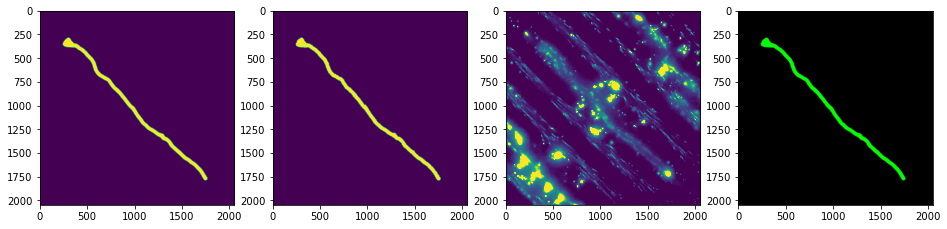

In [13]:
i = 5

tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB,gutmask_stack,red_stack)
#tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
mx = np.percentile(red_stack_bs[i],98)
mn = np.percentile(red_stack_bs[i],5)
rgb = (np.dstack((fp_stack[i],tp_stack[i],fn_stack[i]))-mn)/(mx-mn)

plt.figure(figsize = [16,4])
plt.subplot(141)
plt.imshow(predictions_CB[i])
plt.subplot(142)
plt.imshow(gutmask_stack[i])
plt.subplot(143)
plt.imshow(red_stack_bs[i],vmin = mn,vmax = mx)
plt.subplot(144)
plt.imshow(rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


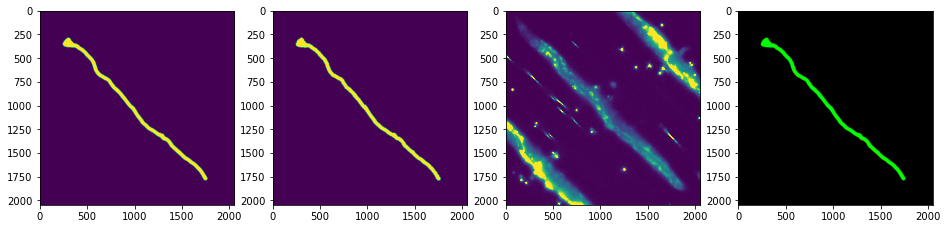

In [14]:
tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB,gutmask_stack,green_stack)
#tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
mx = np.percentile(green_stack_bs[i],98)
mn = np.percentile(green_stack_bs[i],5)
rgb = (np.dstack((fp_stack[i],tp_stack[i],fn_stack[i]))-mn)/(mx-mn)

plt.figure(figsize = [16,4])
plt.subplot(141)
plt.imshow(predictions_CB[i])
plt.subplot(142)
plt.imshow(gutmask_stack[i])
plt.subplot(143)
plt.imshow(green_stack_bs[i],vmin = mn,vmax = mx)
plt.subplot(144)
plt.imshow(rgb)

In [17]:
i = 6

# tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB,gutmask_stack,red_stack)
# #tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
# mx = np.percentile(red_stack_bs[i],98)
# mn = np.percentile(red_stack_bs[i],5)
# rgb = (np.dstack((fp_stack[i],tp_stack[i],fn_stack[i]))-mn)/(mx-mn)

# plt.figure(figsize = [16,4])
# plt.subplot(141)
# plt.imshow(predictions_CB[i])
# plt.subplot(142)
# plt.imshow(gutmask_stack[i])
# plt.subplot(143)
# plt.imshow(red_stack_bs[i],vmin = mn,vmax = mx)
# plt.subplot(144)
# plt.imshow(rgb)

# tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB,gutmask_stack,green_stack)
# #tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
# mx = np.percentile(green_stack_bs[i],98)
# mn = np.percentile(green_stack_bs[i],5)
# rgb = (np.dstack((fp_stack[i],tp_stack[i],fn_stack[i]))-mn)/(mx-mn)

# plt.figure(figsize = [16,4])
# plt.subplot(141)
# plt.imshow(predictions_CB[i])
# plt.subplot(142)
# plt.imshow(gutmask_stack[i])
# plt.subplot(143)
# plt.imshow(green_stack_bs[i],vmin = mn,vmax = mx)
# plt.subplot(144)
# plt.imshow(rgb)

8.375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29.38095238095238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


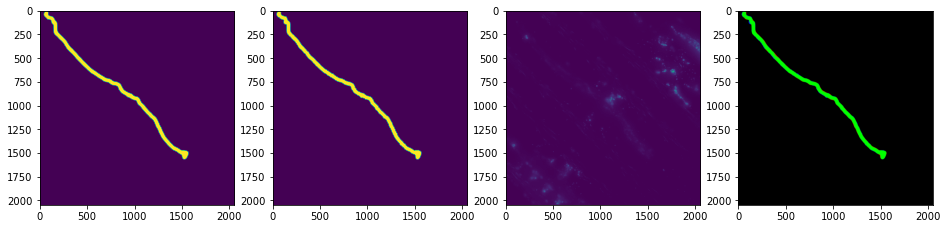

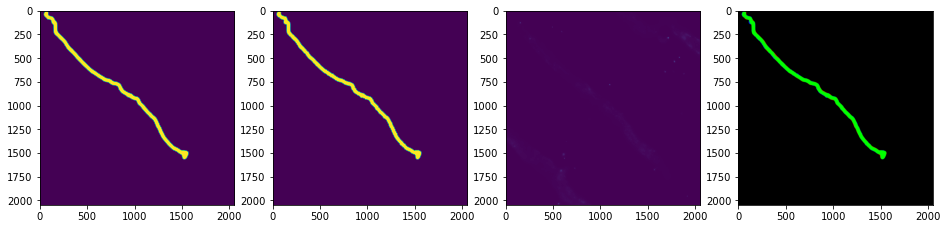

In [25]:
i = 7

tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],red_stack[i])
#tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
mx = np.percentile(red_stack_bs[i],98)
mn = np.percentile(red_stack_bs[i],5)
rgb = (np.dstack((fp_stack,tp_stack,fn_stack))-mn)/(mx-mn)
print(np.max(rgb))

plt.figure(figsize = [16,4])
plt.subplot(141)
plt.imshow(predictions_CB[i])
plt.subplot(142)
plt.imshow(gutmask_stack[i])
plt.subplot(143)
plt.imshow(red_stack_bs[i])#,vmin = mn,vmax = mx)
plt.subplot(144)
plt.imshow(rgb)

tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack[i])
#tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
mx = np.percentile(green_stack_bs[i],98)
mn = np.percentile(green_stack_bs[i],5)
rgb = (np.dstack((fp_stack,tp_stack,fn_stack))-mn)/(mx-mn)
print(np.max(rgb))

plt.figure(figsize = [16,4])
plt.subplot(141)
plt.imshow(predictions_CB[i])
plt.subplot(142)
plt.imshow(gutmask_stack[i])
plt.subplot(143)
plt.imshow(green_stack_bs[i])#,vmin = mn,vmax = mx)
plt.subplot(144)
plt.imshow(rgb)

11.692307692307692


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6.520833333333333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


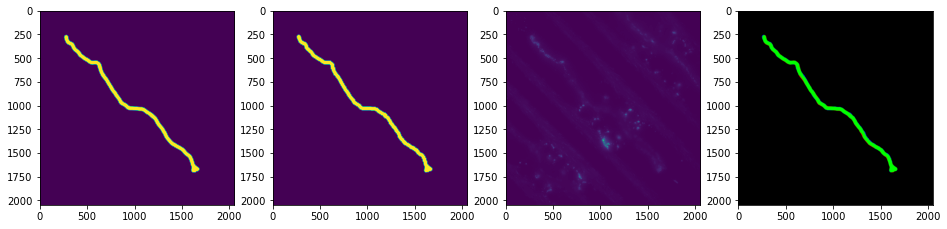

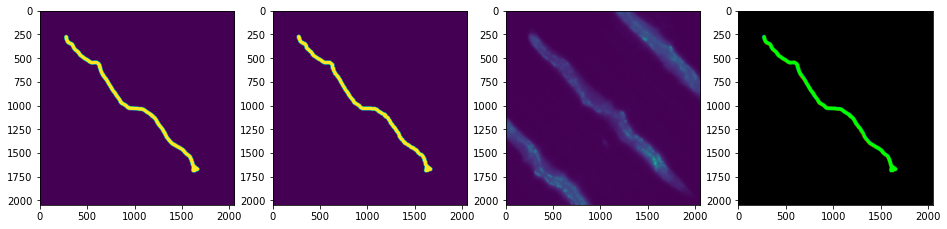

In [27]:
i = 11

tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],red_stack[i])
#tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
mx = np.percentile(red_stack_bs[i],98)
mn = np.percentile(red_stack_bs[i],5)
rgb = (np.dstack((fp_stack,tp_stack,fn_stack))-mn)/(mx-mn)
print(np.max(rgb))

plt.figure(figsize = [16,4])
plt.subplot(141)
plt.imshow(predictions_CB[i])
plt.subplot(142)
plt.imshow(gutmask_stack[i])
plt.subplot(143)
plt.imshow(red_stack_bs[i])#,vmin = mn,vmax = mx)
plt.subplot(144)
plt.imshow(rgb)

tp_stack,fn_stack,fp_stack = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack[i])
#tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
mx = np.percentile(green_stack_bs[i],98)
mn = np.percentile(green_stack_bs[i],5)
rgb = (np.dstack((fp_stack,tp_stack,fn_stack))-mn)/(mx-mn)
print(np.max(rgb))

plt.figure(figsize = [16,4])
plt.subplot(141)
plt.imshow(predictions_CB[i])
plt.subplot(142)
plt.imshow(gutmask_stack[i])
plt.subplot(143)
plt.imshow(green_stack_bs[i])#,vmin = mn,vmax = mx)
plt.subplot(144)
plt.imshow(rgb)

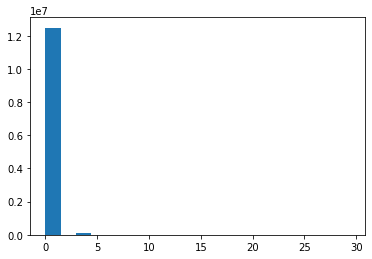

In [22]:
plt.hist(rgb.flatten(),bins = 20);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


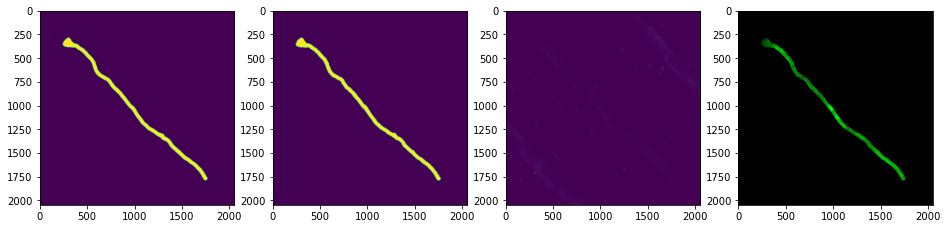

In [23]:
i = 5

tp_green,fn_green,fp_green = compute_analysis_stacks_fluor(predictions_CB[i],gutmask_stack[i],green_stack_bs[i])
mx = np.percentile(green_stack_bs[i],95)
mn = np.percentile(green_stack_bs[i],5)
rgb = (np.dstack((fn_green,tp_green,fp_green))-mn)/(mx-mn)

plt.figure(figsize = [16,4])
plt.subplot(141)
plt.imshow(predictions_CB[i])
plt.subplot(142)
plt.imshow(gutmask_stack[i])
plt.subplot(143)
plt.imshow((green_stack_bs[i]-mn)/(mx-mn))
plt.subplot(144)
plt.imshow(rgb)

In [50]:
p,r,f1 = compute_precision_recall_f1_imagewise(predictions_CB,gutmask_stack)
pg,rg,f1g = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,green_stack_bs)
pr,rr,f1r = compute_precision_recall_f1_fluor_imagewise(predictions_CB,gutmask_stack,red_stack_bs)

In [ ]:
df.loc[len(df)] = {'model':model_path,'gutmask_precision':}

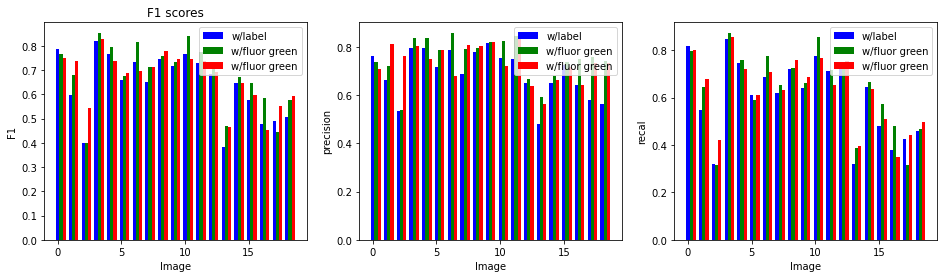

In [52]:
plt.figure(figsize = [16,4])

plt.subplot(131)
x = np.arange(len(f1))
bar_width = 0.25
plt.bar(x, f1, width=bar_width, align='center', label='w/label', color='b')
plt.bar(x + bar_width, f1g, width=bar_width, align='center', label='w/fluor green', color='g')
plt.bar(x + 2*bar_width, f1r, width=bar_width, align='center', label='w/fluor green', color='r')
plt.xlabel('Image')
plt.ylabel('F1')
plt.title('F1 scores')
plt.legend()

plt.subplot(132)
x = np.arange(len(f1))
bar_width = 0.25
plt.bar(x, p, width=bar_width, align='center', label='w/label', color='b')
plt.bar(x + bar_width, pg, width=bar_width, align='center', label='w/fluor green', color='g')
plt.bar(x + 2*bar_width, pr, width=bar_width, align='center', label='w/fluor green', color='r')
plt.xlabel('Image')
plt.ylabel('precision')
plt.title('')
plt.legend()

plt.subplot(133)
x = np.arange(len(f1))
bar_width = 0.25
plt.bar(x, r, width=bar_width, align='center', label='w/label', color='b')
plt.bar(x + bar_width, rg, width=bar_width, align='center', label='w/fluor green', color='g')
plt.bar(x + 2*bar_width, rr, width=bar_width, align='center', label='w/fluor green', color='r')
plt.xlabel('Image')
plt.ylabel('recall')
plt.title('')
plt.legend()


plt.show()

#### using bactmask

In [22]:
p,c,f1 = compute_precision_recall_f1(predictions_CB,bactmask_stack)
print(p,c,f1)

0.4320948295021817 0.6369334968316585 0.5148893886872713


In [23]:
pg,cg,f1g = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,green_stack_bs)
print(pg,cg,f1g)

0.6064797060466228 0.6356204204136761 0.6207082303876386


In [24]:
pr,cr,f1r = compute_precision_recall_f1_fluor(predictions_CB,bactmask_stack,red_stack_bs)
print(pr,cr,f1r)

0.5804200753780218 0.614708989816023 0.5970726486291826


In [25]:
iou = compute_iou(predictions_CB,bactmask_stack)
print(iou)

0.34670103678819375
